# [1.2.4 Rozwiązywanie zadania klasyfikacji](http://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-sieci.html#org7777810)

Zaimplementować funkcję softmax dla warstwy wyjściowej sieci neuronowej. Sprawdzić szybkość i skuteczność w wariancie, gdy sieć używa funkcji softmax na ostatniej warstwie i gdy jest użyta zwykła funkcja aktywacji. Softmax wymaga też odpowiednich zmian w algorytmie uczenia, uwzględniających pochodną fukcji.

Przeprowadzić eksperymenty na zbiorach:

* rings3-regular,
* easy,
* xor3.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import copy

## Model

In [27]:

class MLP_classification:

    def __init__(self, layers, weights, biases, function='softmax', visualize_weights=False):
        self.layers = copy.deepcopy(layers)
        self.weights = copy.deepcopy(weights)
        self.biases = copy.deepcopy(biases)

        self.derivative_w = []
        self.derivative_b = []
        self.visualize_weights = visualize_weights

        if function == 'softmax':
            self.function = self.softmax
            self.functionGradient = self.softmaxDerivative

        else:
            self.function = self.sigmoid
            self.functionGradient = self.sigmoidGradient

    def forward(self, inputs):
        """
        performs forward propagation
        """
        # activations and linear combinations passed to activation function
        self.activations = []
        self.z_values = []

        activations = inputs
        self.activations.append(activations)
        for i in range(len(self.layers) - 2):
            outputs = activations @ self.weights[i] + self.biases[i]
            self.z_values.append(outputs)
            activations = self.sigmoid(outputs)
            self.activations.append(activations)

        self.weights[-1].shape
        results = activations @ self.weights[-1] + self.biases[-1]
        self.z_values.append(results)
        activations = self.function(results)
        self.activations.append(activations)
        return activations

    def backpropagation(self, y):
        deltas = [None] * len(self.weights)

        if self.function == self.softmax:
            out = []
            for elem_x, elem_y in zip(self.activations[-1], y):
                error = elem_y - elem_x
                x = elem_x.reshape(elem_x.shape[0], )
                si_sj = - x * x.reshape(self.layers[-1], 1)
                s_der = np.diag(x) + si_sj
                out.append(s_der @ error)

            out = np.array(out)
            deltas[-1] = copy.deepcopy(out)
        elif self.function == self.sigmoid:
            deltas[-1] = (y - self.activations[-1]) * self.sigmoidGradient(self.activations[-1])

        for i in reversed(range(len(deltas) - 1)):
            deltas[i] = ((self.weights[i + 1] @ deltas[i + 1].T) * self.sigmoidGradient(self.z_values[i]).T).T

        m = y.shape[0]

        derivative_b = [None] * len(deltas)
        derivative_w = [None] * len(deltas)

        for i, d in enumerate(deltas):
            derivative_w[i] = (d.T @ self.activations[i]).T / m
            derivative_b[i] = (d.T @ np.ones((m, 1))).T / m

        return derivative_w, derivative_b

    def train(self, x, y, batch_size=20, epochs=500, alpha=0.1, verbose=False, momentum=False, rmsprop=False,
              lambda_moment=0.5, beta=0.5):

        p = np.random.permutation(len(y))

        if self.function == self.softmax:
            b = np.zeros((y.size, y.max() + 1))
            b[np.arange(y.size), y.flatten()] = 1
            y = b

        x = x[p]
        y = y[p]

        momentum_w = [np.zeros(w.shape) for w in self.weights]
        momentum_b = [np.zeros(b.shape) for b in self.biases]

        rmsprop_w = [np.zeros(w.shape) for w in self.weights]
        rmsprop_b = [np.zeros(b.shape) for b in self.biases]

        for epoch in range(epochs):
            i = 0

            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                y_hat = self.forward(x_batch)
                derivative_w, derivative_b = self.backpropagation(y_batch)

                for j, weight in enumerate(self.weights):

                    if momentum:
                        momentum_w[j] = momentum_w[j] * lambda_moment + derivative_w[j]
                        self.weights[j] = weight + alpha * momentum_w[j]

                    elif rmsprop:
                        rmsprop_w[j] = beta * rmsprop_w[j] + (1 - beta) * derivative_w[j] ** 2
                        self.weights[j] = weight + alpha * (derivative_w[j] / np.sqrt(rmsprop_w[j]))

                    else:
                        self.weights[j] = weight + alpha * derivative_w[j]

                for j, bias in enumerate(self.biases):

                    if momentum:
                        momentum_b[j] = momentum_b[j] * lambda_moment + derivative_b[j]
                        self.biases[j] = bias + alpha * momentum_b[j]

                    elif rmsprop:
                        rmsprop_b[j] = beta * rmsprop_b[j] + (1 - beta) * derivative_b[j] ** 2
                        self.biases[j] = bias + alpha * (derivative_b[j] / np.sqrt(rmsprop_b[j]))

                    else:
                        self.biases[j] = bias + alpha * derivative_b[j]

            if self.visualize_weights:
                if epoch % 100 == 0:
                    print("Error in epoch {} = {}".format(epoch, np.linalg.norm(self.activations[-1] - y_batch)))
                    network_structure = np.asarray(layers)
                    network = visNN.DrawNN(network_structure, self.weights)
                    network.draw()
            else:
                print(f"Error in epoch {epoch} = {metrics.log_loss(np.argmax(y_batch, axis =1), self.activations[-1])}\tAccuracy in epoch = {metrics.accuracy_score(np.argmax(y_batch, axis =1),np.argmax(self.activations[-1], axis =1))}", end='\r')
                
    @staticmethod
    def softmax(x):
        e_x = np.exp(x.T - np.max(x, axis=1).T).T
        return (e_x.T / e_x.sum(axis=1).T).T

    @staticmethod
    def softmaxDerivative(x, y):
        
        si_sj = x.flatten() * x.reshape(x.shape[0])
        
        return x - y

    @staticmethod
    def sigmoid(x):
        return np.exp(x) / (1 + np.exp(x))

    @staticmethod
    def sigmoidGradient(x):
        def sigmoid(x):
            return np.exp(x) / (1 + np.exp(x))

        return sigmoid(x) * (1 - sigmoid(x))

In [28]:
def generate_weights_and_biases(layers, lower, upper):

    weights = []
    biases = []

    for i in range(len(layers) - 1):
        weights.append(np.random.uniform(lower, upper, layers[i] * layers[i + 1]).reshape(layers[i], layers[i + 1]))
        biases.append(np.random.uniform(lower, upper, layers[i + 1]).reshape(1, layers[i+1]))

    return weights, biases

# Testowanie implementacji
## rings3-regular

In [19]:
train_df = pd.read_csv('../data/rings3-regular-training.csv')
test_df = pd.read_csv('../data/rings3-regular-test.csv')

In [20]:
train_df

,x,y,c
0,-93.563317,-76.345110,0
1,1.060114,-16.727040,0
2,24.396099,40.358822,0
3,-94.595137,-97.889250,0
4,-85.331382,-56.736933,0
...,...,...,...
1495,-3.227585,-69.846357,2
1496,-82.598085,-51.758017,2
1497,-46.601078,-21.654871,2
1498,-59.106450,-44.528442,2


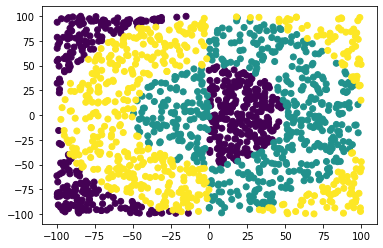

In [21]:
plt.scatter(train_df['x'], train_df['y'], c=train_df['c'])
plt.show()

In [33]:
x = np.asarray(train_df.iloc[:,0:2])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

x_test = np.asarray(test_df.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y = np.asarray(train_df.iloc[:,2]).reshape(-1, 1)
y_test = np.asarray(test_df.iloc[:,2]).reshape(-1, 1)


layers=[2, 128, 128, 128, 3]
weights, biases = generate_weights_and_biases(layers, -1, 1)

mlp = MLP_classification(layers, weights, biases, function='softmax')
        
mlp.train(x, y, epochs = 200, batch_size=32, alpha=0.1)

predictions_b = mlp.forward(x_test)
result = np.argmax(predictions_b, axis = 1)



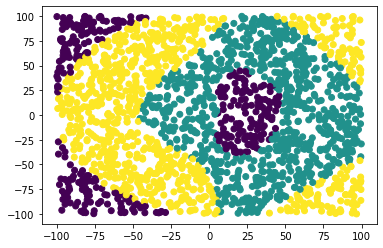

In [34]:
plt.scatter(test_df['x'], test_df['y'], c=result)
plt.show()

In [35]:
metrics.accuracy_score(test_df['c'], result )

0.909